In [1]:
# Recommendation: `conda install --channel conda-forge geopandas`
import numpy as np
import math
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import entropy 
import shapely

In [2]:
def splits_to_regions_binary(row, splits):
    if splits is None:
        return 0
    if len(splits) == 0:
        return 0

    num = 0
    for v in splits:
        num = 2 * num + row[v]
    return num

In [3]:
pa_precincts = gpd.read_file('../data/pa/PA_2020_vtds/')
pa_precincts = pa_precincts.to_crs("EPSG:4269")
pa_precincts['GEOID20'] = pa_precincts['GEOID20'].astype(str)

print([x for x in pa_precincts.columns if "POP" in x])
print([x for x in pa_precincts.columns if x.startswith("G18GOV")])
print(pa_precincts.shape)
pa_precincts.sample(n=5)

['TOTPOP19', 'TOTPOP10', 'HPOP19', 'HPOP10', 'NHPOP19', 'NHPIPOP19', 'NHPOP10', '2MOREPOP19', '2MOREPOP10', 'ASIANPOP19', 'ASIANPOP10', 'AMINPOP19', 'AMINPOP10', 'BPOP19', 'BPOP10', 'NHPIPOP10', 'WPOP19', 'WPOP10']
['G18GOVRWAG', 'G18GOVDWOL', 'G18GOVGGLO', 'G18GOVLKRA']
(9178, 72)


,GEOID20,G18GOVRWAG,G18USSDCAS,NAME,G18USSLKER,VTDST,STATEFP,G18USSGGAL,COUNTYFP,G18USSRBAR,...,AMINPOP10,BCVAP19,BPOP19,BPOP10,NHPIPOP10,WPOP19,WCVAP19,WPOP10,CVAP19,geometry
420,42003003880,50.0,91.0,MCKEESPORT WARD 10 DISTRICT 02,1.0,003880,42,0.0,003,54.0,...,0.0,18.617021,23.936170,50.0,0.0,360.063492,289.862434,428.0,336.763636,"POLYGON ((-79.88377 40.34430, -79.88356 40.344..."
9057,42133000400,844.0,508.0,HELLAM DISTRICT 02,16.0,000400,42,9.0,133,872.0,...,3.0,0.000000,0.000000,46.0,0.0,3185.866571,2622.412199,3226.0,2680.102297,"POLYGON ((-76.61992 40.05470, -76.61644 40.054..."
1489,42007000680,26.0,22.0,EASTVALE,1.0,000680,42,2.0,007,31.0,...,0.0,1.702128,1.617021,4.0,0.0,217.553354,189.176829,219.0,189.699413,"POLYGON ((-80.31760 40.77213, -80.31689 40.772..."
337,42003003000,479.0,521.0,JEFFERSON HILLS DISTRICT 01,8.0,003000,42,4.0,003,501.0,...,1.0,64.285714,63.642857,18.0,0.0,2150.881663,1477.304727,1840.0,1582.299448,"POLYGON ((-79.97384 40.30159, -79.97365 40.301..."
2099,42017001330,367.0,653.0,LOWER MAKEFIELD DISTRICT SOUTH DIVISION 03,7.0,001330,42,7.0,017,377.0,...,7.0,10.000000,29.000000,100.0,1.0,1714.000000,1280.000000,1762.0,1405.000000,"POLYGON ((-74.83008 40.23825, -74.82971 40.238..."


In [4]:
pop = "TOTPOP19"
d_votes = "G18GOVDWOL"
r_votes = "G18GOVRWAG"

In [5]:
pa_precincts['REPRESENTATIVE_POINT'] =  pa_precincts.representative_point() # https://gis.stackexchange.com/a/414263
pa_precincts['RP_LON'] = pa_precincts['REPRESENTATIVE_POINT'].apply(lambda p: p.x)
pa_precincts['RP_LAT'] = pa_precincts['REPRESENTATIVE_POINT'].apply(lambda p: p.y)

print(pa_precincts.shape)
pa_precincts.sample(n=5)

(9178, 75)


,GEOID20,G18GOVRWAG,G18USSDCAS,NAME,G18USSLKER,VTDST,STATEFP,G18USSGGAL,COUNTYFP,G18USSRBAR,...,BPOP10,NHPIPOP10,WPOP19,WCVAP19,WPOP10,CVAP19,geometry,REPRESENTATIVE_POINT,RP_LON,RP_LAT
6727,42101001918,2.0,182.0,PHILADELPHIA WARD 19 PRECINCT 18,0.0,001918,42,0.0,101,4.0,...,165.0,0.0,273.020949,44.566953,151.0,432.998985,"POLYGON ((-75.14317 39.98777, -75.14251 39.987...",POINT (-75.14092 39.98671),-75.140920,39.986712
2251,42017002720,130.0,302.0,WARMINSTER DISTRICT 16,7.0,002720,42,2.0,017,139.0,...,197.0,0.0,1367.461627,818.550974,1201.0,1252.875000,"POLYGON ((-75.08550 40.19431, -75.08520 40.194...",POINT (-75.07848 40.19015),-75.078484,40.190148
1943,42015000390,327.0,93.0,SOUTH CREEK,3.0,000390,42,2.0,015,320.0,...,4.0,0.0,1123.000000,825.000000,1095.0,850.000000,"POLYGON ((-76.83057 42.00199, -76.83044 42.001...",POINT (-76.78836 41.95294),-76.788355,41.952942
1164,4200300F141,75.0,149.0,SHALER WARD 02 DISTRICT 05,2.0,00F141,42,2.0,003,83.0,...,1.0,0.0,379.166034,316.380455,517.0,331.811798,"POLYGON ((-79.96083 40.51051, -79.95983 40.510...",POINT (-79.95565 40.50844),-79.955654,40.508442
3529,42045001170,276.0,490.0,HAVERFORD TWP WD 01 PCT 03,5.0,001170,42,1.0,045,277.0,...,72.0,0.0,1283.437156,1005.145985,1271.0,1198.691451,"POLYGON ((-75.33854 39.97289, -75.33831 39.973...",POINT (-75.33562 39.97151),-75.335616,39.971507


In [6]:
pa_precincts["Dem_Ratio"] = pa_precincts[d_votes]/(pa_precincts[d_votes] + pa_precincts[r_votes])
pa_precincts["Rep_Ratio"] = pa_precincts[r_votes]/(pa_precincts[d_votes] + pa_precincts[r_votes])
pa_precincts.sample(n=5)

,GEOID20,G18GOVRWAG,G18USSDCAS,NAME,G18USSLKER,VTDST,STATEFP,G18USSGGAL,COUNTYFP,G18USSRBAR,...,WPOP19,WCVAP19,WPOP10,CVAP19,geometry,REPRESENTATIVE_POINT,RP_LON,RP_LAT,Dem_Ratio,Rep_Ratio
608,42003005670,113.0,401.0,PENN HILLS WARD 07 DISTRICT 03,7.0,005670,42,2.0,003,119.0,...,530.247805,529.639024,624.0,926.666667,"POLYGON ((-79.79528 40.47601, -79.79502 40.477...",POINT (-79.78659 40.48064),-79.786590,40.480640,0.783525,0.216475
8507,42125000490,96.0,157.0,CHARLEROI DISTRICT 03,3.0,000490,42,1.0,125,99.0,...,704.151014,554.921341,811.0,567.409674,"POLYGON ((-79.90565 40.13536, -79.90545 40.135...",POINT (-79.90189 40.13347),-79.901890,40.133471,0.622047,0.377953
134,42003000841,144.0,239.0,BRENTWOOD DISTRICT 07,9.0,000841,42,1.0,003,144.0,...,922.572843,744.609941,956.0,834.322012,"POLYGON ((-79.98613 40.37031, -79.98555 40.371...",POINT (-79.98057 40.37330),-79.980565,40.373299,0.619048,0.380952
3070,42039000100,139.0,115.0,CONNEAUT LAKE,2.0,000100,42,1.0,039,138.0,...,537.274454,447.411260,634.0,448.324224,"POLYGON ((-80.31992 41.60356, -80.31991 41.603...",POINT (-80.30795 41.60294),-80.307953,41.602940,0.448413,0.551587
7246,42101003937,103.0,274.0,PHILADELPHIA WARD 39 PRECINCT 37,1.0,003937,42,3.0,101,107.0,...,864.005825,546.588026,817.0,654.330431,"POLYGON ((-75.17031 39.92188, -75.17002 39.923...",POINT (-75.16749 39.92225),-75.167493,39.922249,0.729659,0.270341


In [7]:
# %%time
def split_this(df, n_districts, n_split=1, pop_col = "POPULATION", dem_col = "G18GOVD", rep_col = "G18GOVR", n_sample_angles=None):
    # print(n_districts)
    if n_districts != 1:
        # Get district ratios:
        if n_districts % 2 == 0:
            part_a = n_districts/2
            part_b = n_districts/2
        else:
            part_a = math.ceil(n_districts/2)
            part_b = math.floor(n_districts/2)

        # Get Total Population
        pop_total = df[pop_col].sum()

        # Get Population Center
        pop_center_LON = (df['RP_LON'] * df[pop_col]).sum()/pop_total
        pop_center_LAT =  (df['RP_LAT'] * df[pop_col]).sum()/pop_total

        # Re-center LAT/LON relative to the Population Center
        df['RECENTERED_LON'] = df['RP_LON'] - pop_center_LON
        df['RECENTERED_LAT'] = df['RP_LAT'] - pop_center_LAT

        # Get Angle by using ARCTAN(RECENTERED_LAT, RECENTERED_LON)
        df['RECENTERED_RATIO'] = df['RECENTERED_LAT']/df['RECENTERED_LON']
        df['RECENTERED_ANGLE'] = np.degrees(np.arctan2(df['RECENTERED_LAT'], df['RECENTERED_LON']))
        df['RECENTERED_ANGLE'] = df['RECENTERED_ANGLE'].apply(lambda x: x if x > 0 else x + 360)


        ## LOOP for d in 0 to 359 ##
        start_angles = np.linspace(0,359,360)
        if n_sample_angles:
            start_angles = np.random.choice(start_angles, size=n_sample_angles)
        # Set Tracker for Angle Ranges and Competitiveness
        angle_ranges = []

        for d in start_angles:
            # Reset Angle to be Relative to d
            df['RESETTED_ANGLE'] = df['RECENTERED_ANGLE'] - d
            df['RESETTED_ANGLE'] = df['RESETTED_ANGLE'].apply(lambda x: x if x > 0 else (x+360))
            df = df.sort_values('RESETTED_ANGLE').reset_index(drop=True)

            # Spin Clock Around till you achieve the desired ratio
            i = 0
            captured_pop = 0
            while captured_pop < (part_a)/(part_a+part_b)*pop_total:
                captured_pop += df.loc[i, pop_col]
                i += 1
            final_angle = df.loc[i-1, 'RECENTERED_ANGLE']

            ## Check if angle range loops past 360 for conditions:

            a1, a2 = d, final_angle
            if a1 < a2:
                df[f'SPLIT_{n_split}'] = df['RECENTERED_ANGLE'].apply(lambda x: 1 if a1 <= x <= a2 else 0)
            elif a1 > a2:
                df[f'SPLIT_{n_split}'] = df['RECENTERED_ANGLE'].apply(lambda x: 1 if ((x >= a1) or (x <= a2)) else 0)

            df_a = df.loc[df[f'SPLIT_{n_split}'] == 1].copy().reset_index(drop=True)
            df_b = df.loc[df[f'SPLIT_{n_split}'] == 0].copy().reset_index(drop=True)

            # Calculate Entropy, want to maximize
            # TODO: Just calculate once and do 1-p for the other.
            summed_pops_a = df_a[[pop_col, dem_col, rep_col]].sum()
            entropy_a = entropy([(summed_pops_a[dem_col]/summed_pops_a[pop_col]), (summed_pops_a[rep_col]/summed_pops_a[pop_col])], base=2)

            summed_pops_b = df_b[[pop_col, dem_col, rep_col]].sum()
            entropy_b = entropy([(summed_pops_b[dem_col]/summed_pops_b[pop_col]), (summed_pops_b[rep_col]/summed_pops_b[pop_col])], base=2)

            angle_ranges.append({"start":d, "end":final_angle, "entropy_a":entropy_a, "entropy_b":entropy_b})


        ars = pd.DataFrame(angle_ranges)
        ars['entropy_prod'] = ars['entropy_a']*ars["entropy_b"]
        # ars = ars.sort_values("entropy_prod", ascending=False).reset_index(drop=True)
        ars = ars.sort_values("entropy_a", ascending=False).reset_index(drop=True)

        a1, a2 = ars.iloc[0]["start"], ars.iloc[0]["end"]
        ## Check if angle range loops past 360 for conditions:
        if a1 < a2:
            df[f'SPLIT_{n_split}'] = df['RECENTERED_ANGLE'].apply(lambda x: 1 if a1 <= x <= a2 else 0)
        elif a1 > a2:
            df[f'SPLIT_{n_split}'] = df['RECENTERED_ANGLE'].apply(lambda x: 1 if ((x >= a1) or (x <= a2)) else 0)

        df_a = df.loc[df[f'SPLIT_{n_split}'] == 1].copy().reset_index(drop=True)
        df_b = df.loc[df[f'SPLIT_{n_split}'] == 0].copy().reset_index(drop=True)

        split_this(df_a, part_a, n_split=n_split+1, pop_col = pop_col, dem_col = dem_col, rep_col = rep_col, n_sample_angles=n_sample_angles)
        split_this(df_b, part_b, n_split=n_split+1, pop_col = pop_col, dem_col = dem_col, rep_col = rep_col, n_sample_angles=n_sample_angles)

        
    else:
        holder.append(df)

holder = []   
n_districts = 18
split_this(df=pa_precincts, n_districts=n_districts, pop_col=pop, dem_col=d_votes, rep_col=r_votes)

In [8]:
all_districts = pd.concat(holder).reset_index(drop=True)
split_columns = [c for c in all_districts.columns if c.startswith("SPLIT_")]

for c in split_columns:
    all_districts[c] = all_districts[c].fillna(0)

all_districts['DISTRICT'] = all_districts.apply(splits_to_regions_binary, splits=split_columns, axis=1)

In [9]:
all_districts['DISTRICT'].nunique()

18

In [10]:
# Shuffle for coloring
n_districts = all_districts['DISTRICT'].nunique()
random_districts = np.random.choice(np.linspace(0,n_districts-1,n_districts), size=n_districts, replace=False, p=None)
shuffle_dict = dict(zip(all_districts["DISTRICT"].unique(), random_districts))
all_districts["SHUFFLED"] = all_districts["DISTRICT"].apply(lambda x: shuffle_dict[x])

In [11]:
print(all_districts.groupby("SHUFFLED").sum()[pop].sum())
all_districts.groupby("SHUFFLED").sum()[pop]

12791530.000000002


SHUFFLED
0.0     711073.449316
1.0     708794.613008
2.0     711272.631043
3.0     711027.412416
4.0     710288.313291
5.0     711324.554484
6.0     714115.374450
7.0     710568.466483
8.0     712279.300266
9.0     708177.070595
10.0    712774.257936
11.0    708468.912381
12.0    709994.754811
13.0    710323.767132
14.0    710751.329999
15.0    708659.102690
16.0    709275.533994
17.0    712361.155707
Name: TOTPOP19, dtype: float64

<AxesSubplot:>

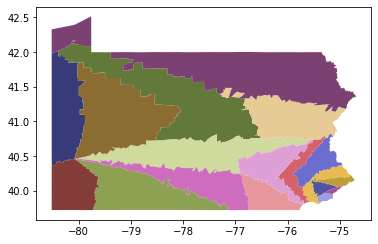

In [12]:
districts_df = all_districts.dissolve(by="SHUFFLED")
districts_df.plot(cmap="tab20b")

In [13]:
all_districts.columns

Index(['GEOID20', 'G18GOVRWAG', 'G18USSDCAS', 'NAME', 'G18USSLKER', 'VTDST',
       'STATEFP', 'G18USSGGAL', 'COUNTYFP', 'G18USSRBAR', 'G18GOVDWOL',
       'G18GOVGGLO', 'G18GOVLKRA', 'VTDST20', 'G16TRERVOI', 'NAMELSAD20',
       'AWATER20', 'LSAD20', 'G16AUDGSWE', 'NAME20', 'G16AUDRBRO',
       'G16PRERTRU', 'G16TRELBAB', 'COUNTYFP20', 'G16TREGCOM', 'G16PREDCLI',
       'STATEFP20', 'G16USSRTOO', 'G16PRECCAS', 'G16USSLCLI', 'G16AUDDDEP',
       'G16USSDMCG', 'FUNCSTAT20', 'INTPTLAT20', 'G16TREDTOR', 'G16ATGRRAF',
       'G16ATGDSHA', 'G16PREGSTE', 'ALAND20', 'G16PRELJOH', 'G16AUDLMIN',
       'INTPTLON20', 'VTDI20', 'MTFCC20', 'TOTPOP19', 'TOTPOP10', 'HPOP19',
       'HCVAP19', 'HPOP10', 'NHPICVAP19', 'NHCVAP19', 'NHPOP19', 'NHPIPOP19',
       'NHPOP10', '2MOREPOP19', '2MORECVAP1', '2MOREPOP10', 'ASIANPOP19',
       'ASIANCVAP1', 'ASIANPOP10', 'AMINPOP19', 'AMINCVAP19', 'AMINPOP10',
       'BCVAP19', 'BPOP19', 'BPOP10', 'NHPIPOP10', 'WPOP19', 'WCVAP19',
       'WPOP10', 'CVAP19', 'geo

## Step by Step Review

In [14]:
def split_review(input_df, split, split_cols, plot_party=False):
    input_df['TEMP_DISTRICT'] = input_df.apply(splits_to_regions_binary, splits=split_columns[:split], axis=1)
    n_districts = input_df['TEMP_DISTRICT'].nunique()
    # random_districts = np.random.choice(np.linspace(0,n_districts-1,n_districts), size=n_districts, replace=False, p=None)
    random_districts = np.linspace(0,n_districts-1,n_districts)
    shuffle_dict = dict(zip(input_df["TEMP_DISTRICT"].unique(), random_districts))
    input_df["TEMP_DISTRICT"] = input_df["TEMP_DISTRICT"].apply(lambda x: shuffle_dict[x])

    districts_df = input_df.dissolve(by = "TEMP_DISTRICT")
    
    if plot_party:
        base = districts_df.plot(cmap="RdBu", column="Dem_Ratio", legend=True, vmin=0, vmax=1, edgecolor='black')
    else:
        base = districts_df.plot(cmap="tab20b", edgecolor='black')

    points = []
    for x in range(2**split):
        sub = input_df.loc[input_df['TEMP_DISTRICT'] == x]
        if sub.shape[0] == 0:
            continue
        pop_center_LON = (sub['RP_LON'] * sub[pop]).sum()/sub[pop].sum()
        pop_center_LAT =  (sub['RP_LAT'] * sub[pop]).sum()/sub[pop].sum()
        point = shapely.geometry.Point(pop_center_LON, pop_center_LAT)
        points.append(point)
    pop_center_df = gpd.GeoDataFrame(geometry=points)
    pop_center_df.plot(ax=base, color="white", linewidth=1.0, edgecolor="black")

    return districts_df


### Initial = 0

,geometry,GEOID20,G18GOVRWAG,G18USSDCAS,NAME,G18USSLKER,VTDST,STATEFP,G18USSGGAL,COUNTYFP,...,RECENTERED_RATIO,RECENTERED_ANGLE,RESETTED_ANGLE,SPLIT_1,SPLIT_2,SPLIT_3,SPLIT_4,SPLIT_5,DISTRICT,SHUFFLED
TEMP_DISTRICT,,,,,,,,,,,,,,,,,,,,,
0.0,"POLYGON ((-80.24951 39.72100, -80.25516 39.721...",42081000090,326.0,76.0,COGAN HOUSE,3.0,000090,42,4.0,081,...,-0.086961,175.029998,176.029998,1,1,1,1,1.0,31.0,10.0


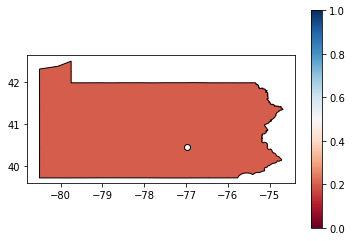

In [15]:
split_review(input_df=all_districts, split=0, split_cols=split_columns, plot_party=True)

### Split = 1

,geometry,GEOID20,G18GOVRWAG,G18USSDCAS,NAME,G18USSLKER,VTDST,STATEFP,G18USSGGAL,COUNTYFP,...,RECENTERED_RATIO,RECENTERED_ANGLE,RESETTED_ANGLE,SPLIT_1,SPLIT_2,SPLIT_3,SPLIT_4,SPLIT_5,DISTRICT,SHUFFLED
TEMP_DISTRICT,,,,,,,,,,,,,,,,,,,,,
0.0,"POLYGON ((-80.30602 39.72126, -80.30607 39.721...",42081000090,326.0,76.0,COGAN HOUSE,3.0,000090,42,4.0,081,...,-0.086961,175.029998,176.029998,1,1,1,1,1.0,31.0,10.0
1.0,"POLYGON ((-76.69305 39.72110, -76.69689 39.721...",42071001802,414.0,219.0,WARWICK DISTRICT MILLPORT,9.0,001802,42,4.0,071,...,0.026567,1.521822,2.521822,0,1,1,1,1.0,15.0,17.0


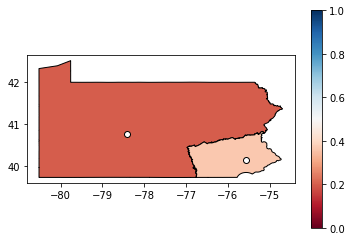

In [16]:
split_review(input_df=all_districts, split=1, split_cols=split_columns, plot_party=True)

### Split = 2

,geometry,GEOID20,G18GOVRWAG,G18USSDCAS,NAME,G18USSLKER,VTDST,STATEFP,G18USSGGAL,COUNTYFP,...,RECENTERED_RATIO,RECENTERED_ANGLE,RESETTED_ANGLE,SPLIT_1,SPLIT_2,SPLIT_3,SPLIT_4,SPLIT_5,DISTRICT,SHUFFLED
TEMP_DISTRICT,,,,,,,,,,,,,,,,,,,,,
0.0,"MULTIPOLYGON (((-80.51799 40.40266, -80.51799 ...",42081000090,326.0,76.0,COGAN HOUSE,3.0,000090,42,4.0,081,...,-0.086961,175.029998,176.029998,1,1,1,1,1.0,31.0,10.0
1.0,"MULTIPOLYGON (((-80.30865 39.72128, -80.30923 ...",42041000202,401.0,421.0,EAST PENNSBORO DISTRICT 08,13.0,000202,42,5.0,041,...,-0.016935,359.029809,0.029809,1,0,1,1,0.0,22.0,6.0
2.0,"POLYGON ((-76.80989 39.93962, -76.80975 39.940...",42071001802,414.0,219.0,WARWICK DISTRICT MILLPORT,9.0,001802,42,4.0,071,...,0.026567,1.521822,2.521822,0,1,1,1,1.0,15.0,17.0
3.0,"POLYGON ((-75.37163 39.82766, -75.37173 39.827...",42101006311,208.0,369.0,PHILADELPHIA WARD 63 PRECINCT 11,2.0,006311,42,4.0,101,...,-0.016852,359.034519,0.034519,0,0,1,1,0.0,6.0,8.0


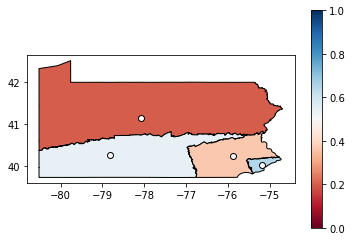

In [17]:
split_review(input_df=all_districts, split=2, split_cols=split_columns, plot_party=True)

### Split = 3

,geometry,GEOID20,G18GOVRWAG,G18USSDCAS,NAME,G18USSLKER,VTDST,STATEFP,G18USSGGAL,COUNTYFP,...,RECENTERED_RATIO,RECENTERED_ANGLE,RESETTED_ANGLE,SPLIT_1,SPLIT_2,SPLIT_3,SPLIT_4,SPLIT_5,DISTRICT,SHUFFLED
TEMP_DISTRICT,,,,,,,,,,,,,,,,,,,,,
0.0,"MULTIPOLYGON (((-80.20634 41.86046, -80.20629 ...",42081000090,326.0,76.0,COGAN HOUSE,3.0,000090,42,4.0,081,...,-0.086961,175.029998,176.029998,1,1,1,1,1.0,31.0,10.0
1.0,"MULTIPOLYGON (((-80.51799 40.40206, -80.51799 ...",42121000320,143.0,72.0,MINERAL,2.0,000320,42,1.0,121,...,-8.132194,97.010357,98.010357,1,1,0,1,0.0,26.0,0.0
2.0,"MULTIPOLYGON (((-79.95011 40.44042, -79.95014 ...",42041000202,401.0,421.0,EAST PENNSBORO DISTRICT 08,13.0,000202,42,5.0,041,...,-0.016935,359.029809,0.029809,1,0,1,1,0.0,22.0,6.0
3.0,"POLYGON ((-80.18323 39.72118, -80.18420 39.721...",42129001580,184.0,119.0,MOUNT PLEASANT DISTRICT RIDGEVIEW,5.0,001580,42,2.0,129,...,-0.016236,359.069837,0.069837,1,0,0,1,0.0,18.0,5.0
4.0,"POLYGON ((-76.84835 40.09417, -76.84854 40.094...",42071001802,414.0,219.0,WARWICK DISTRICT MILLPORT,9.0,001802,42,4.0,071,...,0.026567,1.521822,2.521822,0,1,1,1,1.0,15.0,17.0
5.0,"POLYGON ((-75.47266 39.82680, -75.47331 39.827...",42017001790,601.0,852.0,NEW BRITAIN DISTRICT EAST,26.0,001790,42,9.0,017,...,0.201144,11.372932,12.372932,0,1,0,1,0.0,10.0,2.0
6.0,"POLYGON ((-75.43974 39.91136, -75.43973 39.911...",42101006311,208.0,369.0,PHILADELPHIA WARD 63 PRECINCT 11,2.0,006311,42,4.0,101,...,-0.016852,359.034519,0.034519,0,0,1,1,0.0,6.0,8.0
7.0,"POLYGON ((-75.37463 39.82577, -75.37488 39.825...",42101000603,19.0,468.0,PHILADELPHIA WARD 06 PRECINCT 03,2.0,000603,42,9.0,101,...,-0.085293,175.124866,176.124866,0,0,0,1,0.0,2.0,3.0


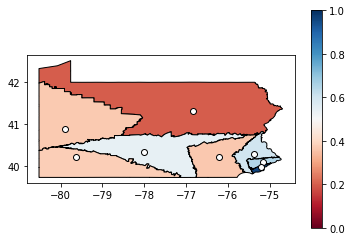

In [18]:
split_review(input_df=all_districts, split=3, split_cols=split_columns, plot_party=True)

### Split = 4

,geometry,GEOID20,G18GOVRWAG,G18USSDCAS,NAME,G18USSLKER,VTDST,STATEFP,G18USSGGAL,COUNTYFP,...,RECENTERED_RATIO,RECENTERED_ANGLE,RESETTED_ANGLE,SPLIT_1,SPLIT_2,SPLIT_3,SPLIT_4,SPLIT_5,DISTRICT,SHUFFLED
TEMP_DISTRICT,,,,,,,,,,,,,,,,,,,,,
0.0,"MULTIPOLYGON (((-78.08733 41.62394, -78.08859 ...",42081000090,326.000000,76.000000,COGAN HOUSE,3.000000,000090,42,4.000000,081,...,-0.086961,175.029998,176.029998,1,1,1,1,1.0,31.0,10.0
1.0,"MULTIPOLYGON (((-80.20635 41.85916, -80.20635 ...",42049000410,71.000000,144.000000,ERIE WARD 04 DISTRICT 06,2.000000,000410,42,2.000000,049,...,-0.247390,166.104575,167.104575,1,1,1,0,0.0,28.0,4.0
2.0,"MULTIPOLYGON (((-80.51799 40.39964, -80.51799 ...",42121000320,143.000000,72.000000,MINERAL,2.000000,000320,42,1.000000,121,...,-8.132194,97.010357,98.010357,1,1,0,1,0.0,26.0,0.0
3.0,"MULTIPOLYGON (((-80.09475 40.45962, -80.09468 ...",42005000160,323.000000,146.000000,EAST FRANKLIN DISTRICT NORTHERN,4.000000,000160,42,1.000000,005,...,-0.017094,359.020667,0.020667,1,1,0,0,0.0,24.0,7.0
4.0,"MULTIPOLYGON (((-79.92167 40.45276, -79.92205 ...",42041000202,401.000000,421.000000,EAST PENNSBORO DISTRICT 08,13.000000,000202,42,5.000000,041,...,-0.016935,359.029809,0.029809,1,0,1,1,0.0,22.0,6.0
5.0,"MULTIPOLYGON (((-79.92436 40.43455, -79.92474 ...",4200300B920,16.000000,188.000000,PITTSBURGH WARD 21 DISTRICT 01,0.000000,00B920,42,1.000000,003,...,-0.067825,176.119840,177.119840,1,0,1,0,0.0,20.0,16.0
6.0,"POLYGON ((-79.95732 40.38971, -79.95754 40.389...",42129001580,184.000000,119.000000,MOUNT PLEASANT DISTRICT RIDGEVIEW,5.000000,001580,42,2.000000,129,...,-0.016236,359.069837,0.069837,1,0,0,1,0.0,18.0,5.0
7.0,"MULTIPOLYGON (((-80.24424 39.72111, -80.24951 ...",4200300D750,111.000000,193.000000,PITTSBURGH WARD 31 DISTRICT 04,1.000000,00D750,42,2.000000,003,...,-0.576013,150.057502,151.057502,1,0,0,0,0.0,16.0,11.0
8.0,"POLYGON ((-76.86403 40.13557, -76.86390 40.136...",42071001802,414.000000,219.000000,WARWICK DISTRICT MILLPORT,9.000000,001802,42,4.000000,071,...,0.026567,1.521822,2.521822,0,1,1,1,1.0,15.0,17.0


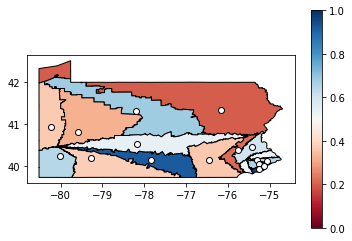

In [19]:
split_review(input_df=all_districts, split=4, split_cols=split_columns, plot_party=True)

### Split = 5

,geometry,GEOID20,G18GOVRWAG,G18USSDCAS,NAME,G18USSLKER,VTDST,STATEFP,G18USSGGAL,COUNTYFP,...,RECENTERED_RATIO,RECENTERED_ANGLE,RESETTED_ANGLE,SPLIT_1,SPLIT_2,SPLIT_3,SPLIT_4,SPLIT_5,DISTRICT,SHUFFLED
TEMP_DISTRICT,,,,,,,,,,,,,,,,,,,,,
0.0,"MULTIPOLYGON (((-76.48810 40.75882, -76.48876 ...",42081000090,326.000000,76.000000,COGAN HOUSE,3.000000,000090,42,4.000000,081,...,-0.086961,175.029998,176.029998,1,1,1,1,1.0,31.0,10.0
1.0,"MULTIPOLYGON (((-78.38096 41.76344, -78.38182 ...",42079002595,380.739693,360.723830,WEST WYOMING WARD 01,3.609447,002595,42,2.609475,079,...,-0.013699,359.215174,0.215174,1,1,1,1,0.0,30.0,14.0
2.0,"MULTIPOLYGON (((-80.20635 41.85916, -80.20635 ...",42049000410,71.000000,144.000000,ERIE WARD 04 DISTRICT 06,2.000000,000410,42,2.000000,049,...,-0.247390,166.104575,167.104575,1,1,1,0,0.0,28.0,4.0
3.0,"MULTIPOLYGON (((-80.51799 40.39964, -80.51799 ...",42121000320,143.000000,72.000000,MINERAL,2.000000,000320,42,1.000000,121,...,-8.132194,97.010357,98.010357,1,1,0,1,0.0,26.0,0.0
4.0,"MULTIPOLYGON (((-80.09475 40.45962, -80.09468 ...",42005000160,323.000000,146.000000,EAST FRANKLIN DISTRICT NORTHERN,4.000000,000160,42,1.000000,005,...,-0.017094,359.020667,0.020667,1,1,0,0,0.0,24.0,7.0
5.0,"MULTIPOLYGON (((-79.92167 40.45276, -79.92205 ...",42041000202,401.000000,421.000000,EAST PENNSBORO DISTRICT 08,13.000000,000202,42,5.000000,041,...,-0.016935,359.029809,0.029809,1,0,1,1,0.0,22.0,6.0
6.0,"MULTIPOLYGON (((-79.92436 40.43455, -79.92474 ...",4200300B920,16.000000,188.000000,PITTSBURGH WARD 21 DISTRICT 01,0.000000,00B920,42,1.000000,003,...,-0.067825,176.119840,177.119840,1,0,1,0,0.0,20.0,16.0
7.0,"POLYGON ((-79.95732 40.38971, -79.95754 40.389...",42129001580,184.000000,119.000000,MOUNT PLEASANT DISTRICT RIDGEVIEW,5.000000,001580,42,2.000000,129,...,-0.016236,359.069837,0.069837,1,0,0,1,0.0,18.0,5.0
8.0,"MULTIPOLYGON (((-80.24424 39.72111, -80.24951 ...",4200300D750,111.000000,193.000000,PITTSBURGH WARD 31 DISTRICT 04,1.000000,00D750,42,2.000000,003,...,-0.576013,150.057502,151.057502,1,0,0,0,0.0,16.0,11.0


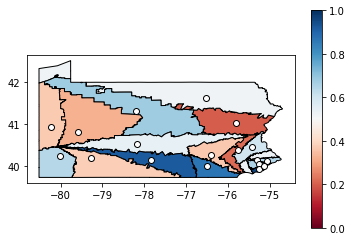

In [20]:
split_review(input_df=all_districts, split=5, split_cols=split_columns, plot_party=True)